# Used Car's Price Prediction model

In [5]:
# All the necessary Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import plotly.express as px
import seaborn as sns
import os

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn import metrics

In [7]:
# Merging all the files of each brand into a single dataframe

df = pd.DataFrame()
df = pd.read_csv("/content/input/carsdataset/Audi.csv")
df['Brand'] = 'Audi'

for dirname, _, filenames in os.walk('/content/input/carsdataset'):
    for i in filenames[1:]:
        df_new = pd.read_csv(dirname+'/'+i)
        df_new['Brand'] = i.split('.')[0].replace(' ','_')
        df = pd.concat([df,df_new])
        df = df.reindex(df.index)

# df['Brand'] = df['Brand'].str.capitalize()        
print(df.shape)

(104995, 10)


## Data Exploration and cleaning

### EDA

In [8]:
df.columns

Index(['model', 'year', 'price', 'transmission', 'mileage', 'fuelType', 'tax',
       'mpg', 'engineSize', 'Brand'],
      dtype='object')

In [9]:
df.isnull().sum()

model            0
year             0
price           14
transmission     0
mileage          0
fuelType         0
tax              0
mpg              0
engineSize       0
Brand            0
dtype: int64

In [10]:
# Removing all the Null Records
df = df.dropna()
df.reset_index(drop=True)
df.isnull().sum()

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
Brand           0
dtype: int64

In [11]:
 df.describe()

,year,price,mileage,tax,mpg,engineSize
count,104981.000000,104981.000000,104981.000000,104981.000000,104981.000000,104981.000000
mean,2017.088149,17552.721864,23309.777817,120.842391,54.781628,1.699949
std,2.137381,10395.329128,21545.605946,63.821790,16.041672,0.572047
min,1970.000000,-1.000000,1.000000,0.000000,0.300000,0.000000
25%,2016.000000,10495.000000,7125.000000,125.000000,46.300000,1.400000
50%,2017.000000,15180.000000,17568.000000,145.000000,54.300000,1.600000
75%,2019.000000,21980.000000,32868.000000,145.000000,62.800000,2.000000
max,2060.000000,159999.000000,323000.000000,580.000000,470.800000,6.600000


In [12]:
# Counting the number of records with -1

df['price'][df['price']<=-1].count()

672

In [13]:
# Dropping the rows with the values of -1 in price 

df.drop(df[df['price'] == -1].index, inplace = True)

In [14]:
 df.describe()

,year,price,mileage,tax,mpg,engineSize
count,99388.000000,99388.000000,99388.000000,99388.000000,99388.000000,99388.000000
mean,2017.076699,17544.767487,23459.800590,120.567724,54.834415,1.695161
std,2.146300,10354.330447,21671.850477,63.952188,16.112249,0.572183
min,1970.000000,450.000000,1.000000,0.000000,0.300000,0.000000
25%,2016.000000,10495.000000,7226.000000,125.000000,46.300000,1.400000
50%,2017.000000,14999.000000,17726.500000,145.000000,54.300000,1.600000
75%,2019.000000,21899.000000,33000.000000,145.000000,62.800000,2.000000
max,2060.000000,159999.000000,323000.000000,580.000000,470.800000,6.600000


In [15]:
 print(df.head(100))
 print(df.tail(100))

    model  year    price transmission  mileage fuelType  tax   mpg  \
396    A3  2015  14990.0    Semi-Auto    30530   Diesel   30  64.2   
441    A3  2019  23995.0    Semi-Auto     2868   Diesel  145  52.3   
489    Q7  2017  35995.0    Semi-Auto    33165   Diesel  200  47.9   
490    Q2  2017  19995.0       Manual    27078   Petrol  125  50.4   
491    Q2  2017  19995.0       Manual    29874   Petrol  125  50.4   
..    ...   ...      ...          ...      ...      ...  ...   ...   
670    A4  2019  29995.0    Automatic    13690   Diesel  145  47.9   
671    Q3  2016  20495.0    Semi-Auto    25125   Diesel  160  50.4   
672    Q5  2019  34995.0    Automatic     6400   Diesel  145  38.2   
673    A3  2019  19495.0       Manual     3265   Petrol  145  47.1   
674    Q3  2017  22995.0    Semi-Auto    17680   Petrol  145  42.2   

     engineSize Brand  
396         2.0  Audi  
441         1.6  Audi  
489         3.0  Audi  
490         1.4  Audi  
491         1.4  Audi  
..          ...

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99388 entries, 396 to 6737
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         99388 non-null  object 
 1   year          99388 non-null  int64  
 2   price         99388 non-null  float64
 3   transmission  99388 non-null  object 
 4   mileage       99388 non-null  int64  
 5   fuelType      99388 non-null  object 
 6   tax           99388 non-null  int64  
 7   mpg           99388 non-null  float64
 8   engineSize    99388 non-null  float64
 9   Brand         99388 non-null  object 
dtypes: float64(3), int64(3), object(4)
memory usage: 8.3+ MB


In [17]:
df.loc[df['Brand'] == 'Merc', 'Brand'] = 'Mercedes'
df.loc[df['Brand'] == 'Vw', 'Brand'] = 'Volkswagen'
df['Brand'].unique()


array(['Audi', 'Volkswagen', 'Vauxhall', 'Mercedes', 'Ford', 'Bmw',
       'Skoda', 'Toyota'], dtype=object)

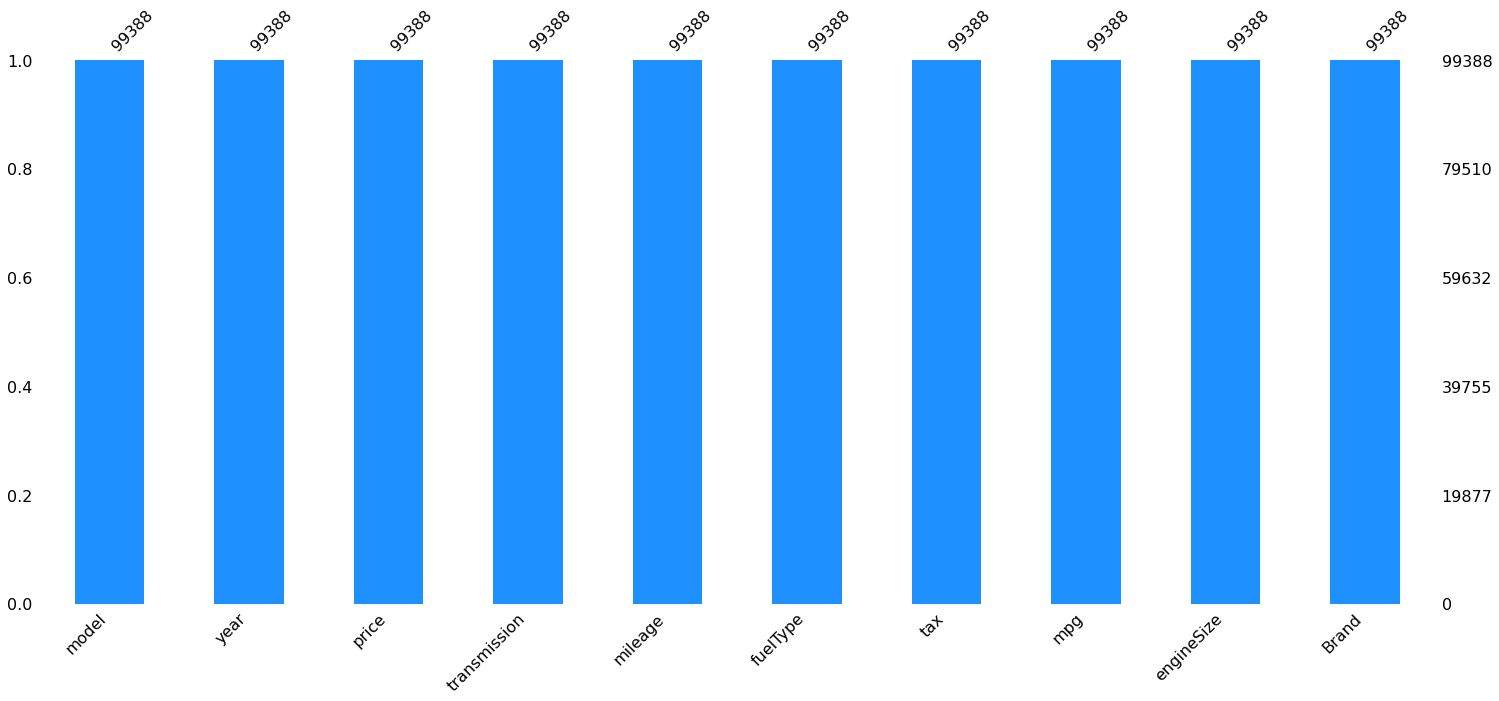

In [18]:
msno.bar(df, color="dodgerblue")

### Visualisation

In [19]:
# Piechart representing the cars distribution basis the Fuel Type

px.pie(df, values=df['fuelType'].value_counts(), names=df['fuelType'].unique(), 
       title='Distribution of Cars basis Fuel Type')

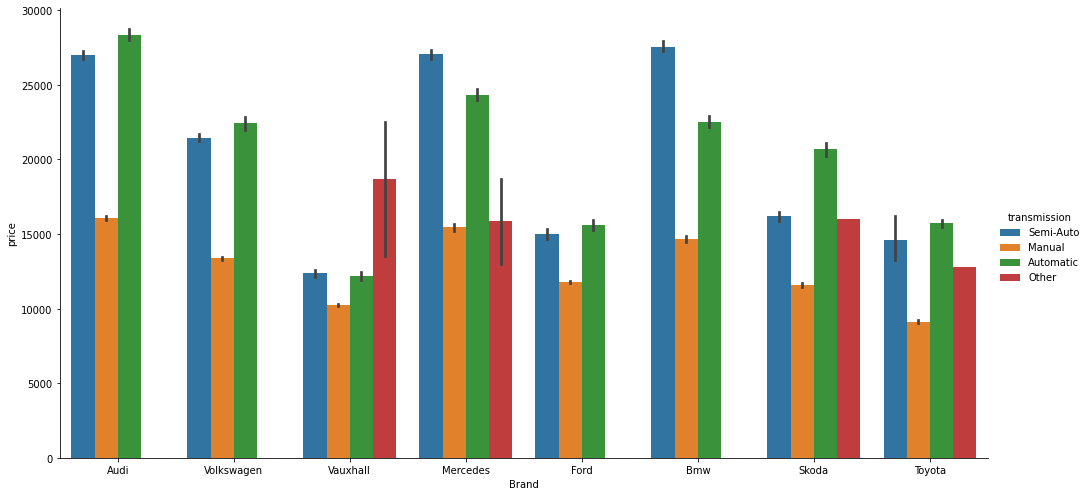

In [20]:
# Bar Plot showing the value of price basis the brand and transmission of the Car

sns.catplot(x='Brand', y ='price', hue='transmission', data=df, kind="bar", aspect=2, height=7)

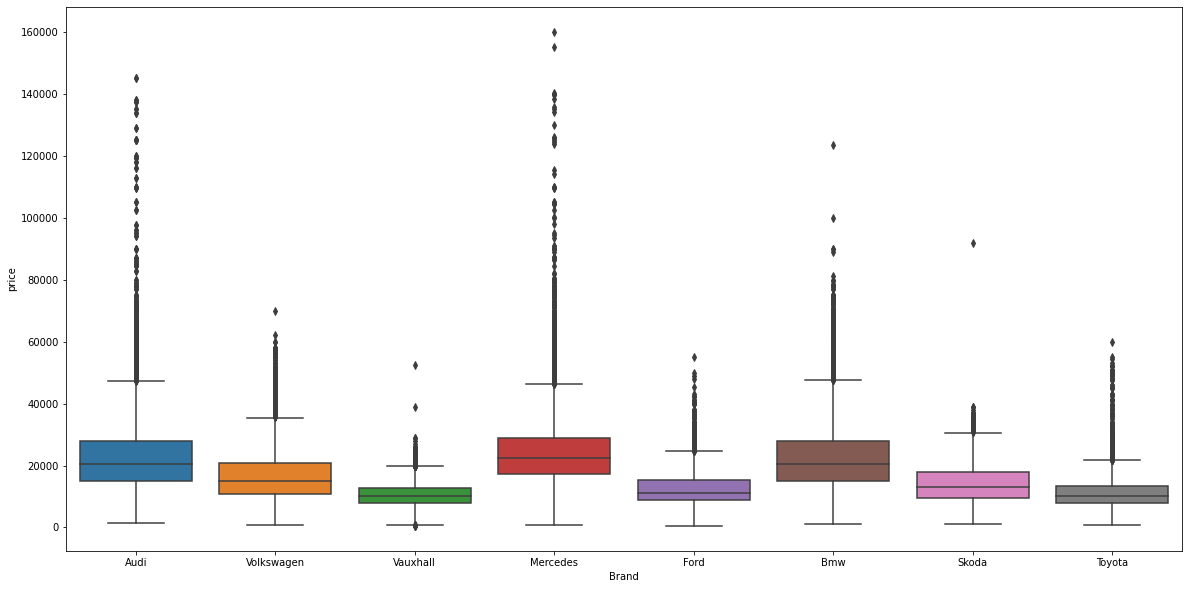

In [21]:
plt.figure(figsize=(20,10))
sns.boxplot(x='Brand', y='price', data=df)

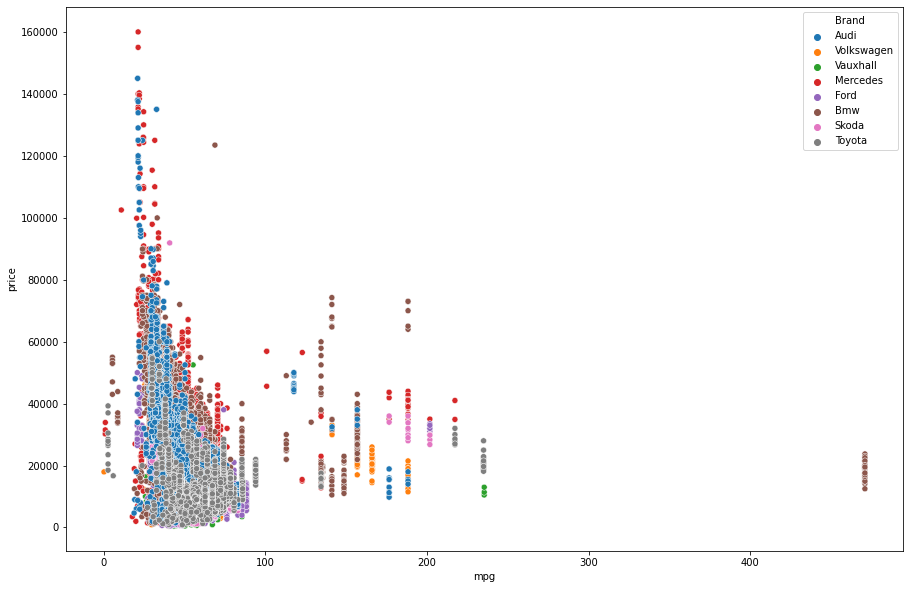

In [22]:
plt.figure(figsize=(15,10))
sns.scatterplot(x='mpg',y='price',hue='Brand',data=df)

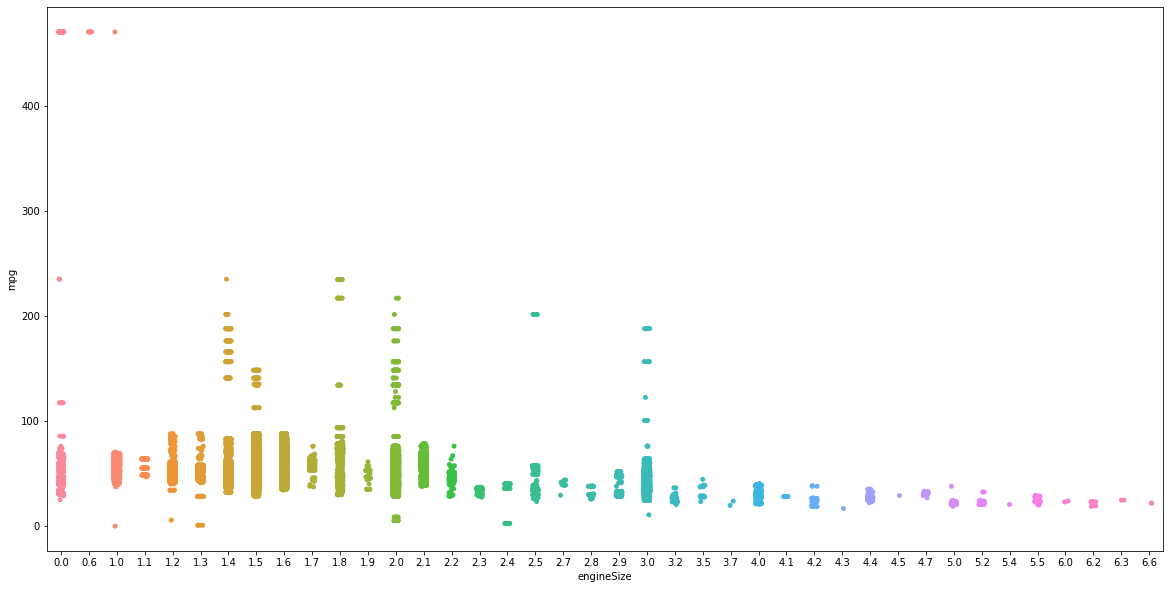

In [23]:
plt.figure(figsize=(20,10))
sns.stripplot(x="engineSize", y="mpg", data=df)

## Data Prepocessing

* There are multiple categorical features
* Using label_encoder we will transform them in numerical features

In [24]:
#Data preprocessing
df_copy = df.copy()

In [25]:
categorical_features = df_copy.select_dtypes(exclude=np.number).columns.to_list()
print(f'Categorical features: {categorical_features}\n\n')
vals = {}

# Encode using LabelEncoder
for feature in categorical_features:
      lab_enc = LabelEncoder()
      lab_enc.fit(list(df_copy[feature].astype(str).values))
      vals[feature] = dict(zip(lab_enc.classes_, lab_enc.transform(lab_enc.classes_)))
      df_copy[feature] = lab_enc.transform(list(df_copy[feature].astype(str).values))
      print(vals[feature])

Categorical features: ['model', 'transmission', 'fuelType', 'Brand']


{' 1 Series': 0, ' 2 Series': 1, ' 3 Series': 2, ' 4 Series': 3, ' 5 Series': 4, ' 6 Series': 5, ' 7 Series': 6, ' 8 Series': 7, ' A Class': 8, ' A1': 9, ' A2': 10, ' A3': 11, ' A4': 12, ' A5': 13, ' A6': 14, ' A7': 15, ' A8': 16, ' Adam': 17, ' Agila': 18, ' Amarok': 19, ' Ampera': 20, ' Antara': 21, ' Arteon': 22, ' Astra': 23, ' Auris': 24, ' Avensis': 25, ' Aygo': 26, ' B Class': 27, ' B-MAX': 28, ' Beetle': 29, ' C Class': 30, ' C-HR': 31, ' C-MAX': 32, ' CC': 33, ' CL Class': 34, ' CLA Class': 35, ' CLC Class': 36, ' CLK': 37, ' CLS Class': 38, ' Caddy': 39, ' Caddy Life': 40, ' Caddy Maxi': 41, ' Caddy Maxi Life': 42, ' California': 43, ' Camry': 44, ' Caravelle': 45, ' Cascada': 46, ' Citigo': 47, ' Combo Life': 48, ' Corsa': 49, ' Crossland X': 50, ' E Class': 51, ' EcoSport': 52, ' Edge': 53, ' Eos': 54, ' Escort': 55, ' Fabia': 56, ' Fiesta': 57, ' Focus': 58, ' Fox': 59, ' Fusion': 60, ' G Class': 61, ' 

In [26]:
df_copy

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,Brand
396,11,2015,14990.0,3,30530,0,30,64.2,2.0,0
441,11,2019,23995.0,3,2868,0,145,52.3,1.6,0
489,107,2017,35995.0,3,33165,0,200,47.9,3.0,0
490,104,2017,19995.0,1,27078,4,125,50.4,1.4,0
491,104,2017,19995.0,1,29874,4,125,50.4,1.4,0
...,...,...,...,...,...,...,...,...,...,...
6733,76,2011,5500.0,0,30000,4,20,58.9,1.0,5
6734,149,2011,4985.0,1,36154,4,125,50.4,1.3,5
6735,149,2012,4995.0,1,46000,0,125,57.6,1.4,5
6736,149,2011,3995.0,1,60700,4,125,50.4,1.3,5


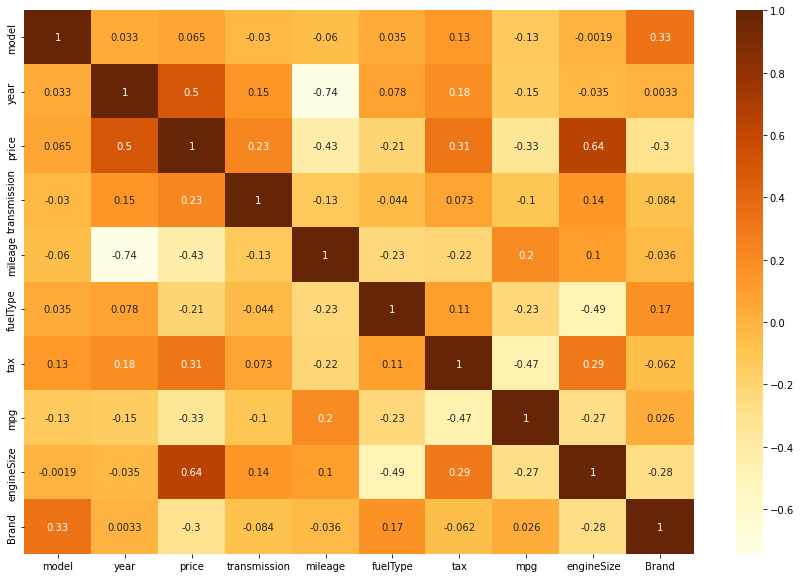

In [27]:
plt.figure(figsize=(15,10))
sns.heatmap(df_copy.corr(), annot = True, cmap = "YlOrBr")

In [28]:
input_columns = df_copy.columns.values.tolist()
input_columns.remove('price')

X = df_copy[input_columns]
Y = df_copy['price']

print(f"X (features):\n\n{X}")

print(f"\nY (target):\n\n{Y}")

X (features):

      model  year  transmission  mileage  fuelType  tax   mpg  engineSize  \
396      11  2015             3    30530         0   30  64.2         2.0   
441      11  2019             3     2868         0  145  52.3         1.6   
489     107  2017             3    33165         0  200  47.9         3.0   
490     104  2017             1    27078         4  125  50.4         1.4   
491     104  2017             1    29874         4  125  50.4         1.4   
...     ...   ...           ...      ...       ...  ...   ...         ...   
6733     76  2011             0    30000         4   20  58.9         1.0   
6734    149  2011             1    36154         4  125  50.4         1.3   
6735    149  2012             1    46000         0  125  57.6         1.4   
6736    149  2011             1    60700         4  125  50.4         1.3   
6737    149  2011             1    45128         4  125  50.4         1.3   

      Brand  
396       0  
441       0  
489       0  
490 

## Modelling

In [29]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

In [30]:
# This funtion will calculate below mentioned factors of all regression metrics like:
# 1. R² or Coefficient of Determination  2. Mean Squared Error(MSE)  3. Root-Mean-Squared-Error(RMSE) 4. Mean-Absolute-Error(MAE).

def regression_metrics(pred_model, x_train, x_test, y_train, y_test):
    # Get predicted values on x_test
    y_pred = pred_model.predict(x_test)

    #R² calculation
    r2 = metrics.r2_score(y_pred=y_pred, y_true=y_test)
    print(f"R²\t: {round(r2, 4)}")
    
    #MSE and RMSE calculation
    mean_sqd_err = metrics.mean_squared_error(y_pred=y_pred, y_true=y_test, squared=True)
    root_mean_sqd_err = metrics.mean_squared_error(y_pred=y_pred, y_true=y_test, squared=False)
    print(f"MSE\t: {round(mean_sqd_err, 2)}")
    print(f"RMSE\t: {round(root_mean_sqd_err, 2)}")

    #5 MAE calculation
    mean_abs_err = metrics.mean_absolute_error(y_pred=y_pred, y_true=y_test)
    print(f"MAE\t: {round(mean_abs_err, 2)}")
    
    #Accuracy calculation of the model
    train_accuracy = round(pred_model.score(x_train, y_train)*100, 2)
    test_accuracy = round(pred_model.score(x_test, y_test)*100, 2)

    return (train_accuracy, test_accuracy)

In [31]:
# Types of algorithms we will be trying for Model Fitting

algorithms_lst = ['Random Forest', 'Decision Trees', 'Linear Regression',  'Bagging', 'XGBoost']
accuracy_columns = ['Training Accuracy', 'Testing Accuracy']

accuracy_df = pd.DataFrame(columns=accuracy_columns, index=algorithms_lst)
accuracy_df.index.name='Algorithm'

In [32]:
# Using Linear Regression
linear_regression = LinearRegression()
linear_regression.fit(x_train, y_train)
print("\t~~~~~~~~~~ Linear Regression ~~~~~~~~~~")
linreg_accuracy = regression_metrics(linear_regression, x_train, x_test, y_train, y_test)

accuracy_df.loc['Linear Regression'] = linreg_accuracy

	~~~~~~~~~~ Linear Regression ~~~~~~~~~~
R²	: 0.7345
MSE	: 28312561.54
RMSE	: 5320.95
MAE	: 3472.53


In [33]:
# Using Decision Tree Regressor
dtree_regressor = DecisionTreeRegressor()
dtree_regressor.fit(x_train, y_train)

print("\t~~~~~~~~~~ Decision Tree Regressor ~~~~~~~~~~")
dtree_accuracy = regression_metrics(dtree_regressor, x_train, x_test, y_train, y_test)

accuracy_df.loc['Decision Trees'] = dtree_accuracy

	~~~~~~~~~~ Decision Tree Regressor ~~~~~~~~~~
R²	: 0.9405
MSE	: 6342328.15
RMSE	: 2518.4
MAE	: 1254.27


In [34]:
# Using Bagging Regressor
bag_regressor = BaggingRegressor()
bag_regressor.fit(x_train, y_train)

print("\t~~~~~~~~~~ Bagging Regressor ~~~~~~~~~~")
bag_accuracy = regression_metrics(bag_regressor, x_train, x_test, y_train, y_test)

accuracy_df.loc['Bagging'] = bag_accuracy

	~~~~~~~~~~ Bagging Regressor ~~~~~~~~~~
R²	: 0.9595
MSE	: 4316984.65
RMSE	: 2077.74
MAE	: 1131.91


In [35]:
# Using Random Forest Regressor
rf_regressor = RandomForestRegressor(random_state=42)
rf_regressor.fit(x_train, y_train)

print("\t~~~~~~~~~~ Random Forest Regressor ~~~~~~~~~~")
rf_accuracy = regression_metrics(rf_regressor, x_train, x_test, y_train, y_test)

accuracy_df.loc['Random Forest'] = rf_accuracy

	~~~~~~~~~~ Random Forest Regressor ~~~~~~~~~~
R²	: 0.9622
MSE	: 4033740.75
RMSE	: 2008.42
MAE	: 1083.4


In [36]:
# Using XGBoost Regressor
xgb_regressor = xgb.XGBRegressor() 
xgb_regressor.fit(x_train, y_train)

print("\t~~~~~~~~~~ XGBoost Regressor ~~~~~~~~~~")
xgb_accuracy = regression_metrics(xgb_regressor, x_train, x_test, y_train, y_test)

accuracy_df.loc['XGBoost'] = xgb_accuracy

[22:59:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	~~~~~~~~~~ XGBoost Regressor ~~~~~~~~~~
R²	: 0.9028
MSE	: 10363378.04
RMSE	: 3219.22
MAE	: 2074.26


### Model accuracies

In [42]:
accuracy_df.astype(str) + '%'

,Training Accuracy,Testing Accuracy
Algorithm,,
Random Forest,99.54%,96.22%
Decision Trees,99.95%,94.05%
Linear Regression,74.02%,73.45%
Bagging,99.34%,95.95%
XGBoost,91.5%,90.28%


In [46]:
acc_array = accuracy_df['Testing Accuracy'].tolist()

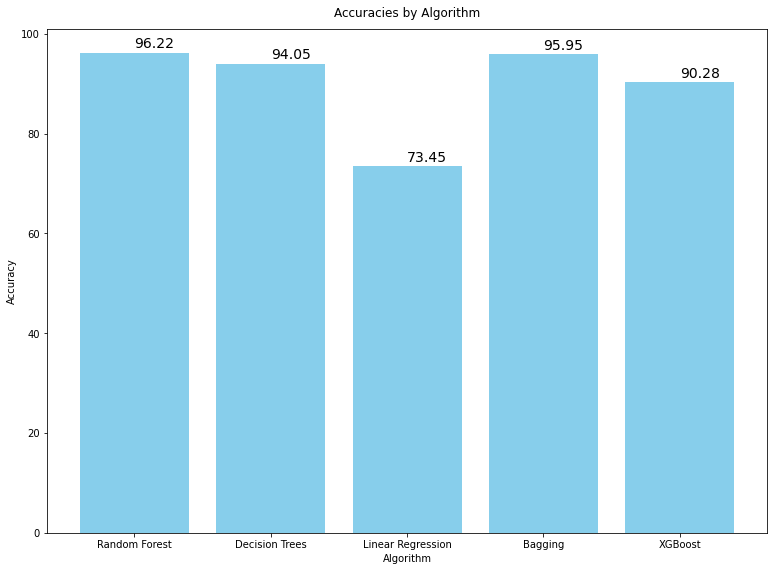

In [47]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_axes([0,0,1,1])
ax.bar(algorithms_lst,accuracy_df['Testing Accuracy'], color="skyBlue")
for index,data in enumerate(acc_array):
    plt.text(x = index, y = data+1, s = f"{data}", fontdict=dict(fontsize=14))
ax.set_title("Accuracies by Algorithm", pad=12)
ax.set_xlabel('Algorithm')
ax.set_ylabel('Accuracy')
plt.show()

## HyperParameter Tuning

* We have indentified that RandomForest Regressor has best accuracy for base model.
* Now we will find the best parameters for RandomForest
* Using GridSearchCV and RandomizedSearchCV

### GridSearchCV

In [48]:
param_grid = {'n_estimators': [80, 100, 120],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [2, 3, 4, None],
               'min_samples_leaf': [1, 2, 4],
               'min_samples_split': [2, 5, 10],
               'bootstrap': [True, False],
            }
# We will first create a base model
rf_grid = RandomForestRegressor()
# Now, we will initilize the grid search model
grid_search = GridSearchCV(estimator = rf_grid, param_grid = param_grid, 
                          cv = 3, n_jobs = -1)

In [ ]:
#Fitting the model with training data and finding the best parmas
grid_search.fit(x_train, y_train)
grid_search.best_params_

In [51]:
rf_grid_new = RandomForestRegressor(bootstrap = False,
 max_depth= None,
 max_features= 'sqrt',
 min_samples_leaf= 1,
 min_samples_split= 5,
 n_estimators= 120)

In [52]:
rf_grid_new.fit(x_train, y_train)

RandomForestRegressor(bootstrap=False, max_features='sqrt', min_samples_split=5,
                      n_estimators=120)

In [53]:
train_accuracy_grid = round(rf_grid_new.score(x_train, y_train)*100, 2)
test_accuracy_grid = round(rf_grid_new.score(x_test, y_test)*100, 2)

In [54]:
print(f'Accuracies of RandomForestRegressor with best_params from GridSearchCV\n\nTrain accuracy = {train_accuracy_grid}\nTest accuracy = {test_accuracy_grid}')

Accuracies of RandomForestRegressor with best_params from GridSearchCV

Train accuracy = 99.6
Test accuracy = 96.58


### RandomizedSearchCV

In [55]:
#We are defining the parameters for RandomForestRegressor which will be used to find the best model
random_grid = {'n_estimators': [100, 200, 400, 600, 800],
               'max_features': [8, 'auto', 'sqrt'],
               'max_depth': [2, 3, 4, 5, 10, None],
               'min_samples_leaf': [1, 2, 4],
               'min_samples_split': [2, 5, 10],
               'bootstrap': [True, False],
              }


In [56]:
# We will create a base_model first which needs to be tuned
rf = RandomForestRegressor()
# We will set cross validation to 3 and will use all the cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [ ]:
#We will fit the Randomized search model now
rf_random.fit(x_train, y_train)

In [ ]:
#Lets check for the best params of the model
rf_random.best_params_

In [59]:
#We will now initialize the RandomForestRegressor with tuned paramters
rf_new = RandomForestRegressor(bootstrap= False,
 max_depth=None,
 max_features= 'sqrt',
 min_samples_leaf= 2,
 min_samples_split= 2,
 n_estimators= 100)

In [60]:
#Fitting the models with traing data
rf_new.fit(x_train, y_train)

RandomForestRegressor(bootstrap=False, max_features='sqrt', min_samples_leaf=2)

In [61]:
#Checking the train and test accuracy of the models
train_accuracy1 = round(rf_new.score(x_train, y_train)*100, 2)
test_accuracy1 = round(rf_new.score(x_test, y_test)*100, 2)

In [62]:
print(f'Accuracies of Hypertuned RandomForestRegressor\n\nTrain accuracy = {train_accuracy1}\nTest accuracy = {test_accuracy1}')

Accuracies of Hypertuned RandomForestRegressor

Train accuracy = 99.21
Test accuracy = 96.34


## Prediction Model

### Model Definition

In [63]:
#Now since we have found that the RandomForest regressor has best testing accuracy
#Using the best_params identified using GridSearchCV will be used for intilization
#RandomForestRegressor

rf_for_prediction = RandomForestRegressor(bootstrap = False,
 max_depth= None,
 max_features= 'sqrt',
 min_samples_leaf= 1,
 min_samples_split= 5,
 n_estimators= 120)

rf_for_prediction.fit(x_train, y_train)

RandomForestRegressor(bootstrap=False, max_features='sqrt', min_samples_split=5,
                      n_estimators=120)

In [66]:
# Save the model
import joblib
joblib_file = "UsedCarPricePredictionModel.joblib"
joblib.dump(rf_for_prediction, joblib_file) 

['UsedCarPricePredictionModel.joblib']

### Code

In [67]:
import warnings
from termcolor import colored

warnings.filterwarnings("ignore")
def carSeletion():
  arr = []
  print("Welcome to the Car Price Prediction Model:")
  print("\nPlease select your car's Brand from the available Brands below:")
  for i, j in vals['Brand'].items():
    # print(i, j)
    print(f'{i} = {j+1}')
  arr.append(int(input ("\nEnter the number associated with your Brand from above:"))-1)
  

  df_col = df_copy[df_copy['Brand'] == arr[0]]
  cols = (df_col['model'].unique())
  cols.sort()

  print(f"\nPlease select your car's Model from the available Models below:")
  key_list = list(vals['model'].keys())
  val_list = list(vals['model'].values())
  for i in cols:
    position = val_list.index(i)
    print(f'{i} :{key_list[position]}')
  arr.append(int(input ("\nEnter the number associated with your Model from above:"))-1)
  
  arr.append(int(input ("\nEnter your car's Year of purchase:")))

  print("\nPlease select your car's Transmission type from the available Transmission types below:")
  for i,j in vals['transmission'].items():
    print(f'{i} = {j+1}')
  arr.append(int(input ("\nEnter the number associated with your car's Transmission type from above:"))-1)

  arr.append(int(input ("\nEnter the total number of miles driven: ")))

  print("\nPlease select your car's Fuel type from the available Fuel types below:")
  for i,j in vals['fuelType'].items():
    print(f'{i} = {j+1}')
  arr.append(int(input ("\nEnter the number associated with your car's Fuel type from above:"))-1)

  arr.append(int(input ("\nEnter the amount of Road Tax paid: ")))

  arr.append(int(input ("\nEnter your car's average Miles/gallon: ")))

  arr.append(int(input ("\nEnter your car's Engine Size: ")))

  arr += [arr.pop(0)]

  price = rf_for_prediction.predict([arr])

  # To convert pounds to USD
  low_price = (price[0] - 0.1*price[0])*1.36
  high_price = (price[0] + 0.1*price[0])*1.36

  return ('\nPrice range of car should be between $ {} and $ {}'.format(int(low_price), int(high_price)))

In [69]:
print(df_copy['Brand'])

396     0
441     0
489     0
490     0
491     0
       ..
6733    5
6734    5
6735    5
6736    5
6737    5
Name: Brand, Length: 99388, dtype: int64


### Output

In [68]:
print(colored(carSeletion(),'red', attrs=['bold']))

Welcome to the Car Price Prediction Model:

Please select your car's Brand from the available Brands below:
Audi = 1
Bmw = 2
Ford = 3
Mercedes = 4
Skoda = 5
Toyota = 6
Vauxhall = 7
Volkswagen = 8

Enter the number associated with your Brand from above:1

Please select your car's Model from the available Models below:
9 : A1
10 : A2
11 : A3
12 : A4
13 : A5
14 : A6
15 : A7
16 : A8
104 : Q2
105 : Q3
106 : Q5
107 : Q7
108 : Q8
110 : R8
112 : RS3
113 : RS4
114 : RS5
115 : RS6
116 : RS7
122 : S3
123 : S4
124 : S5
125 : S8
128 : SQ5
129 : SQ7
139 : TT

Enter the number associated with your Model from above:9

Enter your car's Year of purchase:2015

Please select your car's Transmission type from the available Transmission types below:
Automatic = 1
Manual = 2
Other = 3
Semi-Auto = 4

Enter the number associated with your car's Transmission type from above:1

Enter the total number of miles driven: 100

Please select your car's Fuel type from the available Fuel types below:
Diesel = 1
Electric